# Heart disease prediction: Using different attributes to determine the presence of heart disease in patients of Hungary

## Introduction
Heart disease, or cardiovascular disease, refers to conditions affecting the heart, often involving narrowed or blocked blood vessels that can lead to a heart attack. Both men and women face increased risk with age (Jousilahti et al., 1999). High cholesterol can lead to fatty deposits in blood vessels, increasing the risk of blockages and heart attacks (Mayo Clinic, 2023). Research indicates that men tend to have a higher risk at a younger age compared to women (Jousilahti et al., 1999). Age, sex, and cholesterol levels are fundamental factors in cardiovascular health, each playing an important role in determining the risk of an individual in terms of heart disease. With these risk factors in mind, we aim to classify patients' likelihood of heart disease using age, sex, and cholesterol levels.

Therefore, the question we want to answer is: 

How does the combination of **age**, **sex**, and **cholesterol levels** influence the likelihood of developing heart disease in individuals?

In order to answer this question, we will be using the knn classifier. By utilizing the knn classifier, we aim to build a predictive model to classify individuals as either having or not having heart disease in the dataset. The data will be taken from the Hungary Heart Disease database (“reprocessed. Hungarian.data''); a data set intended to determine the presence of heart disease in patients of Hungary. It contains data on 14 variables, including age, sex, etc. 

The columns in the data contains the following information: 

* **age** = age in years
* **sex** = gender of the patients; (1 = male, 0 = female)
* **cp** = chest pain type
* **trestbps** = resting blood pressure 
* **chol** = serum cholestoral in mg/dl
* **fbs** = fasting blood sugar > 120 mg/dl
* **restecg** = resting electrocardiographic results
* **thalach** = maximum heart rate achieved
* **exang** = exercise induced angima 
* **oldpeak** = ST depression induced by exercise relative to rest
* **slope** = the slope of the peak exercise ST segment; (1 = upflow, 2 = flat, 3 = downsloping) 
* **ca** = number of major vessels (0-3) colored by flourosopy
* **thal** = 3 = normal; 6 = fixed defect; 7 = reversable defect
* **num** = diagnosis of heart disease 
 

## Methods 

The methods section contains the following: 

* Preliminary data processing 
* Find the best k-value:
* Analysis of results
* Testing the classification model 

### Preliminary data processing and exploratory data analysis:

1. Import libraries
2. Load the dataset “reprocessed. Hungarian.data”
3. Clean and wrangle the data 
4. Split the data into training and testing set 
5. Data visualization 

#### 1. Import libraries

In [4]:
#setting the seed and loading the needed packages
set.seed(18)
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

#### 2. Load the dataset

We imported the dataset ("reprocessed.Hungarian.data”) from the internet to the file by reading it as a URL.

In [11]:
#loading in the data
url <- "https://raw.githubusercontent.com/ANGUO17/dsci-100-2023w2-group-06/main/heart%2Bdisease/reprocessed.hungarian.data"
data <- read.table(url) 
data

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
40,1,2,140,289,0,0,172,0,0,-9,-9,-9,0
49,0,3,160,180,0,0,156,0,1,2,-9,-9,1
37,1,2,130,283,0,1,98,0,0,-9,-9,-9,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,1,3,110,211,0,0,138,0,0,-9,-9,6,0
47,0,2,140,257,0,0,135,0,1,1,-9,-9,0
53,1,4,130,182,0,0,148,0,0,-9,-9,-9,0


Figure 1

#### 3. Cleaning and wrangling the data 

From the table above, we can see that the data does not come with specified column names, so we need to assign relevant column names and types to all columns. That being said, we will also assign numerical values to non-numerical factors to make it easier to work with. 

We also made a new column named **"diag"** to indicate the sickness levels of the patients. The sickness levels ranges from level 1 to 4 in terms of the presence of heart disease in the patient, while 0 means the patiient is healthy. 

In [13]:
#cleaning the data
data <- data.frame(lapply(data, function(x) gsub("-9", "NA", x)))
           
colnames(data) <- c("age", "sex", "cp", "trestbps", "chol" , "fbs", 
                    "restecg", "thalach", "exang", "oldpeak", "slope", "ca",
                    "thal", "num")

data_processed <- data |>
    mutate(age = as.numeric(age)) |>
    mutate(trestbps = as.numeric(trestbps)) |>
    mutate(chol = as.numeric(chol)) |>
    mutate(thalach = as.numeric(thalach)) |>
    mutate(sex = as_factor(sex)) |>
    mutate(sex = fct_recode(sex, "male" = "1", "female" = "0")) |>
    mutate(cp = as_factor(cp)) |>
    mutate(cp = fct_recode(cp, "typical angina" = "1", "atypical angina" = "2", 
                                        "non-anginal pain" = "3" , "asymptomatic" = "4" )) |>
    mutate(fbs = as_factor(fbs)) |>
    mutate(fbs = fct_recode(fbs, "true" = "1", "false" = "0" )) |>
    mutate(restecg = as_factor(restecg)) |>
    mutate(restecg = fct_recode(restecg, "normal" = "0", "abnormal" = "1" )) |>
    mutate(exang = as_factor(exang)) |>
    mutate(exang = fct_recode(exang, "yes" = "1", "no" = "0" )) |>
    mutate(slope = as_factor(slope)) |>
    mutate(slope = fct_recode(slope, "upsloping" = "1", "flat" = "2", "downsloping" = "3")) |>
    mutate(thal = as_factor(thal)) |>
    mutate(thal = fct_recode(thal, "normal" = "3", "fixed defect" = "6", "reversable defect" = "7" )) |>
    mutate(diagnosis = as_factor(num)) |>
    mutate(diagnosis = fct_recode(diagnosis, "Sick" = "1","Sick" = "2" ,"Sick" = "3","Sick" = "4", "Healthy" = "0" )) |>
    select(age, sex, chol, diagnosis)
                          
data_processed   

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `trestbps = as.numeric(trestbps)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `chol = as.numeric(chol)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `thalach = as.numeric(thalach)`.
Caused by warning:
! NAs introduced by coercion”


age,sex,chol,diagnosis
<dbl>,<fct>,<dbl>,<fct>
40,male,289,Healthy
49,female,180,Sick
37,male,283,Healthy
⋮,⋮,⋮,⋮
48,male,211,Healthy
47,female,257,Healthy
53,male,182,Healthy


Figure 2

#### 4. Split the data into training and testing set 

The data is being split into training and testing data; with 75% being training data and 25% being testing data. We continue to work with the training data by cleaning it up more. Then we use the `group_by` function to group the data by the diagnosis and sex columns, and the `summarize` function to obtain the mean age and mean chol for each group. 

In [52]:
#splitting the data into training and testing sets
data_split <- initial_split(data_processed, prop = 0.75, strata = diagnosis)  

data_training <- training(data_split)

#further cleaning the training data
data_training2 <- data_training |>
   drop_na() |>
   mutate(sex = as.numeric(sex))

data_testing <- testing(data_split)
#summarizing the training data
data_summarized <- data_training2 |>
    group_by(diagnosis, sex) |>
    summarize(mean_age = mean(age, na.rm = TRUE),
              mean_chol = mean(chol, na.rm = TRUE),
              count = n())
data_summarized

`summarise()` has grouped output by 'diagnosis'. You can override using the
`.groups` argument.


diagnosis,sex,mean_age,mean_chol,count
<fct>,<dbl>,<dbl>,<dbl>,<int>
Healthy,1,45.67059,237.6588,85
Healthy,2,46.47619,244.6667,42
Sick,1,49.47692,269.8769,65
Sick,2,49.33333,281.6667,12


Figure 3

#### 5. Data visualization 

Now we can visualize the data with two scatter plots of age vs. chol: for healthy vs. sick males and healthy vs. sick females. Note that the points are coloured by the patients' diagnosis status; healthy or sick. 

Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”


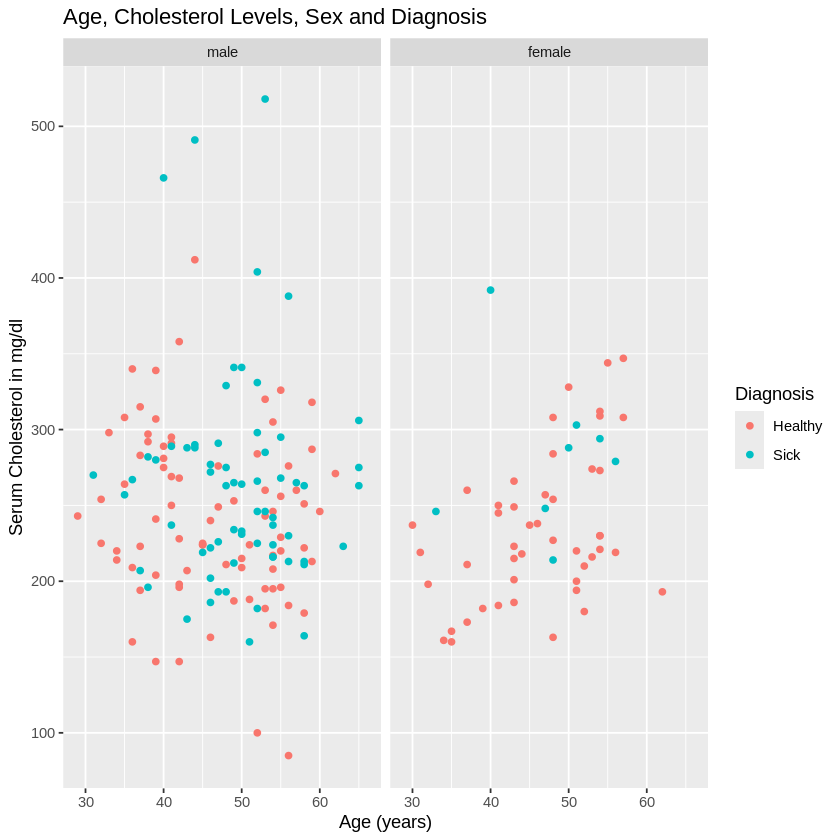

In [15]:
#creating a visualization of the training data
training_plot <- data_training|> ggplot(aes(x = age, y = chol, color = diagnosis)) + 
    geom_point() + facet_grid(cols = vars(sex)) + labs(x = "Age (years)", y = "Serum Cholesterol in mg/dl", color = "Diagnosis", title = "Age, Cholesterol Levels, Sex and Diagnosis" )
training_plot

Figure 4

### Find the best k-value: 

1. Create a recipe 
2. Create a a K-nearest neighbor model specification with uses `neighbors` = `tune()` in its arugument 
3. Perform a 5-fold cross-validation on the training set, stratified based on diag
4. Specify sequence of values for the number of neighbours (1-100)
5. Carry out the workflow and compute the accuracy

To perform the knn classification, we need to first find the most optimal k-value. First, we created the recipe using age, sex, and chol as predictors, as well as scalling and centering the values using `step_scale` and `step_center`. Then, we created a K-nearest neighbor model specification but instead of specifying a particular value for the `neighbors` argument, we inserted `tune()`. Next, we splited the data into 5 folds using the `vfold_cv` argument and specified the values for the number of neighbours to consider. Furthermore, we created a workflow that combines our previously created recipe, model, and tune the model to the specified cross-validation setup and grid of values. Finally, we filtered for accuracy and the mean accuracy for each k-value is calculated and the results are sorted in descending order. 

In [44]:
#creating the recipe
hungary_recipe <- recipe(diagnosis ~ age + sex + chol  , data = data_training2) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#male = 1, female = 2

#creating the model 
hungary_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

hungary_vfold <-  vfold_cv(data_training2, v = 5, strata = diagnosis)

values <- tibble(neighbors = seq(from = 1 , to = 100, by = 1 ))

best_fit <- workflow() |>
    add_recipe(hungary_recipe) |>
    add_model(hungary_spec) |>
    tune_grid(resamples = hungary_vfold , grid = values) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean) |>
    arrange(desc(mean))

best_fit

neighbors,mean
<dbl>,<dbl>
45,0.6519512
46,0.6519512
67,0.6515854
⋮,⋮
18,0.5873171
33,0.5873171
34,0.5873171


Figure 5

### Analysis of results: 

1. Obtain the best k-value
2. Visualization 
3. Perform the classifcation using the best k-value
4. Evaluate the model
5. Look at accuracy, precision, and recall 

#### 1. Obtain the best k-value 

The k-value that maximizes the mean accuracy is selected as our k-value; in this case, it is 5. 

In [34]:
#finding the best k value for the model
best_k <- best_fit |>
    slice(1) |>
    pull(1)

best_k

[1] 5

#### 2. Visualization 

A line plot comparing accuracy and number of neighbours is created to visualize the best value of k that maximizes accuracy.

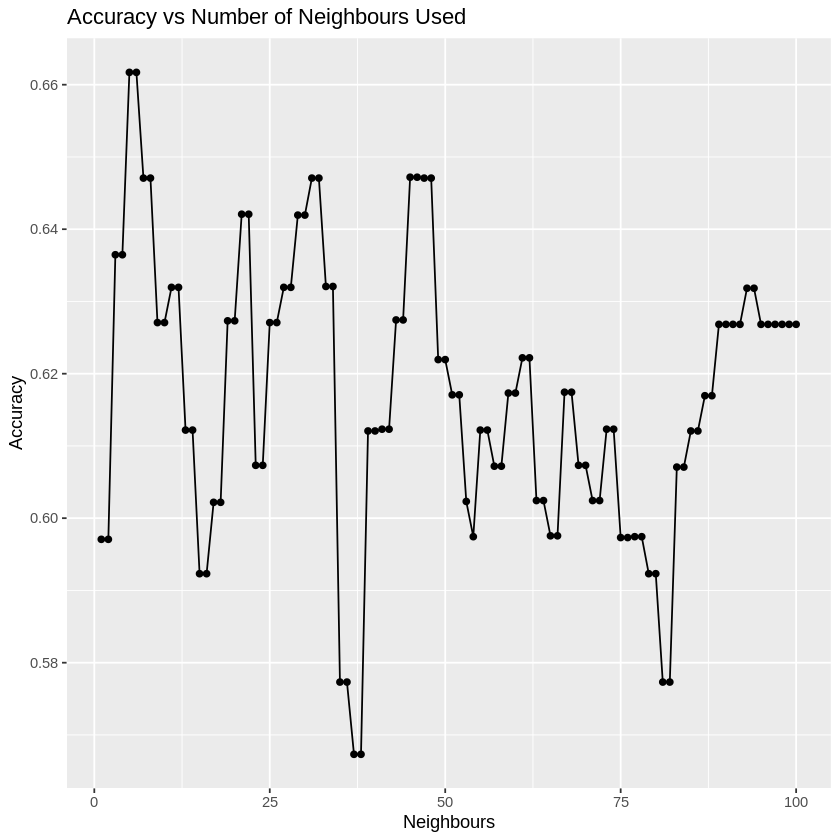

In [35]:
#creating a visualization to see which k value yields the best accuracy
best_k_plot <- best_fit |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy", title = "Accuracy vs Number of Neighbours Used")

best_k_plot

Figure 6

#### 3. Perform the classifcation using the best k-value

The k-nearest neighbour model is refitted using the best k-value.

In [36]:
#using the best k value for the model
hungary_spec2 <- nearest_neighbor(weight_func = 'rectangular', neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

hungary_fit <- workflow() |>
    add_recipe(hungary_recipe) |>
    add_model(hungary_spec2) |>
    fit(data = data_training2)

#### 4. Evaluate the model

Next, we evaluate the model using the testing set and asses the accuracy by assiging it to `hungary_accuracy`. We also looked at the accuracy, precision, and recall to check the performance of the model in classifying individuals with and without heart disease. 

The accuracy metric measures the proportion of correct predictions
* The confusion matrix reveals that 48 out of 67 observations were labelled correctly i.e. 71.64%
  
The precision metric measures the proportion of true positives among all positive predictions
* The precision was calculated around 71.42%
  
The recall metric measures the proportion of true positives among all actual positive cases in the data
* The recall was calculated to be 40%

At last, the confusion matrix provides a breakdown of the model’s predictions.

In [38]:
#further cleaning the testing data
data_testing2 <- data_testing |>
    drop_na() |>
    mutate(sex = as.numeric(sex)) 

hungary_predictions <- predict(hungary_fit, data_testing2) |>
    bind_cols(data_testing2)

#accuracy, precision and recall checks
hungary_accuracy <- hungary_predictions |>
     metrics(truth = diagnosis, estimate = .pred_class) |>
     filter(.metric == "accuracy")
 hungary_accuracy

hungary_predictions |> pull(diagnosis) |> levels()

hungary_precision <- hungary_predictions |>
     precision(truth = diagnosis, estimate = .pred_class, event_level="second") |>
     filter(.metric == "precision")
hungary_precision

hungary_recall <- hungary_predictions |>
    recall(truth = diagnosis, estimate = .pred_class, event_level = "second") |>
    filter(.metric == "recall")
hungary_recall
    
#confusion matrix
hungary_conf_mat <- hungary_predictions |>
     conf_mat(truth = diagnosis , estimate = .pred_class)

hungary_conf_mat   

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6285714


[1] "Healthy" "Sick"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.5


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.5


          Truth
Prediction Healthy Sick
   Healthy      31   13
   Sick         13   13

Figure 7

In [39]:
#comparing our model with a majority classifier
hungary_proportions <- data_training2 |>
    group_by(diagnosis) |>
    summarize(count = n()) |>
    mutate(percent = 100*count/nrow(data_training2))

hungary_proportions

diagnosis,count,percent
<fct>,<int>,<dbl>
Healthy,126,62.68657
Sick,75,37.31343


Figure 8

### Testing the classification model:

1. Load and clean the data
2. Predict for the cleveland data and asses the accuracy, precision, and recall

#### 1. Load the clean the data 

We loaded the processed.cleveland.data from the Heart Disease Database and cleaned the data into a tidy format like what we did for the hungary data previously. 

In [40]:
#loading and cleaning the Clevleland data to see how good our Hungary model works on patients in Cleveland
url <- "https://raw.githubusercontent.com/ANGUO17/dsci-100-2023w2-group-06/main/heart%2Bdisease/processed.cleveland.data"

cleveland_data <- read_csv(url, col_names = FALSE)


colnames(cleveland_data) <- c("age", "sex", "cp", "trestbps", "chol" , "fbs", 
                    "restecg", "thalach", "exang", "oldpeak", "slope", "ca",
                    "thal", "num")


cleveland_data_processed <- cleveland_data |>
    mutate(age = as.numeric(age)) |>
    mutate(trestbps = as.numeric(trestbps)) |>
    mutate(chol = as.numeric(chol)) |>
    mutate(thalach = as.numeric(thalach)) |>
    mutate(sex = as_factor(sex)) |>
    mutate(sex = fct_recode(sex, "male" = "1", "female" = "0")) |>
    mutate(cp = as_factor(cp)) |>
    mutate(cp = fct_recode(cp, "typical angina" = "1", "atypical angina" = "2", 
                                        "non-anginal pain" = "3" , "asymptomatic" = "4" )) |>
    mutate(fbs = as_factor(fbs)) |>
    mutate(fbs = fct_recode(fbs, "true" = "1", "false" = "0" )) |>
    mutate(restecg = as_factor(restecg)) |>
    mutate(restecg = fct_recode(restecg, "normal" = "0", "abnormal" = "1" )) |>
    mutate(exang = as_factor(exang)) |>
    mutate(exang = fct_recode(exang, "yes" = "1", "no" = "0" )) |>
    mutate(slope = as_factor(slope)) |>
    mutate(slope = fct_recode(slope, "upsloping" = "1", "flat" = "2", "downsloping" = "3")) |>
    mutate(thal = as_factor(thal)) |>
    mutate(thal = fct_recode(thal, "normal" = "3", "fixed defect" = "6", "reversable defect" = "7" )) |>
    mutate(diagnosis = as_factor(num)) |>
    mutate(diagnosis = fct_recode(diagnosis, "Sick" = "1","Sick" = "2" ,"Sick" = "3","Sick" = "4", "Healthy" = "0" )) |>
    select(age, sex, chol, diagnosis)

cleveland_data_processed       

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `thal = fct_recode(thal, normal = "3", `fixed defect` = "6",
  `reversable defect` = "7")`.
Caused by warning:
! Unknown levels in `f`: 3, 6, 7”


age,sex,chol,diagnosis
<dbl>,<fct>,<dbl>,<fct>
63,male,233,Healthy
67,male,286,Sick
67,male,229,Sick
⋮,⋮,⋮,⋮
57,male,131,Sick
57,female,236,Sick
38,male,175,Healthy


Figure 9 

#### 2. Predict for the cleveland data and asses the accuracy, precision, and recall

We used our final model to predict for the Cleveland dataset and reported the accuracy, precision, and recall for the predictions. We also reported the confusion matrix by storing it in `cleveland_conf_mat`. 

In [42]:
#using the same process from the Hungary data set
cleveland_clean <- cleveland_data_processed |>
    mutate(sex = as.numeric(sex))

cleveland_predictions <- predict(hungary_fit, cleveland_clean) |>
                      bind_cols(cleveland_data_processed)

#checking for accuracy, precision and recall
cleveland_metrics <- cleveland_predictions |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
cleveland_metrics

cleveland_predictions |> pull(diagnosis) |> levels()

cleveland_precision <- cleveland_predictions |>
     precision(truth = diagnosis, estimate = .pred_class, event_level="second") |>
     filter(.metric == "precision")
cleveland_precision

cleveland_recall <- cleveland_predictions |>
    recall(truth = diagnosis, estimate = .pred_class, event_level = "second") |>
    filter(.metric == "recall")
cleveland_recall

#calling the confusion matrix for Cleveland
cleveland_conf_mat<- cleveland_predictions |>
    conf_mat(truth = diagnosis, estimate = .pred_class)
cleveland_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4983498


[1] "Healthy" "Sick"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.2903226


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.0647482


          Truth
Prediction Healthy Sick
   Healthy     142  130
   Sick         22    9

Figure 10

In [10]:
#majority classfier for Cleveland
cleveland_proportions <- cleveland_data_processed |>
    group_by(diagnosis) |>
    summarize(count = n()) |>
    mutate(percent = 100*count/nrow(cleveland_data_processed))
cleveland_proportions

diagnosis,count,percent
<fct>,<int>,<dbl>
Healthy,164,54.12541
Sick,139,45.87459


Figure 11

## Discussion 

## Bibliography 

1. High cholesterol - Symptoms and causes - Mayo Clinic. (2023, January 11). Mayo Clinic. https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/symptoms-causes/syc-20350800#:~:text=Your%20body%20needs%20cholesterol%20to,to%20flow%20through%20your%20arteries.

2. Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

3. Jousilahti, P., Vartiainen, E., Tuomilehto, J., & Puska, P. (1999). Sex, age, cardiovascular risk factors, and coronary heart disease. Circulation, 99(9), 1165–1172. https://doi.org/10.1161/01.cir.99.9.1165